### Library import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from MLP_utils import *
from Mlp_model import MlpPokemon

### Data import

In [2]:
pokemon = pd.read_csv("data/all_pokemon_data.csv")
pokemon["Legendary Status"] = pokemon["Legendary Status"].astype(int)
pokemon = pokemon.loc[~pokemon["Name"].str.contains("-mega")]
del pokemon["National Dex #"] # redondant column
del pokemon["Height (dm)"] # redondant column
del pokemon["Weight (hg)"] # redondant column
del pokemon["Base Stat Total"] # it is just the sum of all stat, not very new
del pokemon["Name"] # delet pokemon name (not needed)
pokemon.to_csv("data/all_pokemon_filter.csv")

## Data exploration

In [3]:
pokemonNumber = pokemon.select_dtypes(include = "number")

Text(0.5, 1.0, 'Pokemon numeric attributes correlation')

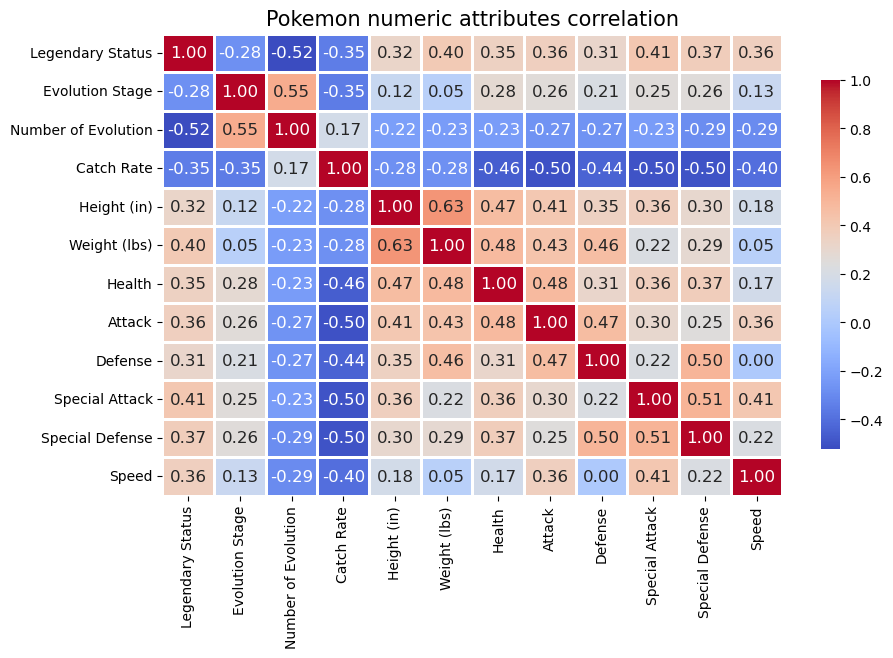

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pokemonNumber.corr(),
    annot=True,                  
    cmap="coolwarm",             
    annot_kws={"size": 12},       
    fmt=".2f",                    
    linewidths=1,                 
    cbar_kws={"shrink": 0.8}      
)
plt.title("Pokemon numeric attributes correlation", size = 15)

### Loading processed data

In [5]:
# X_train is a SMOTE object
# y_train is a SMOTE object
# X_test not a SMOTE object, but cat values has been converted into numeric vectors
# y_test is inchanged
X_train, y_train, X_test, y_test, preprocessor = prepareDataForMlp(pokemon)
X_train_df = encodedDataToDataFrame(preprocessor, X_train)
X_test_df = encodedDataToDataFrame(preprocessor, X_test)

### Training and optimisation of the model

In [6]:
mlp2 = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor)
optimisationOutput = mlp2.optimizeHyperparameters(X_train, y_train, X_test, y_test, preprocessor)

Evaluation of 288 parameter combinaisons...: 100%|██████████| 288/288 [1:04:50<00:00, 13.51s/it] 


===Best model ===
Parameters: {'hiddenDim': 32, 'learningRate': 0.0001, 'batchSize': 16, 'numEpochs': 100, 'nbHiddenLayers': 1}
Mean F-1 score: 0.9931
Mean accuracy: 0.9931


### Model evaluation

- Model parameters

In [7]:
displayParameters(optimisationOutput["bestParams"])

Parameter name: hiddenDim, optimise value: 32
Parameter name: learningRate, optimise value: 0.0001
Parameter name: batchSize, optimise value: 16
Parameter name: numEpochs, optimise value: 100
Parameter name: nbHiddenLayers, optimise value: 1


- Model performances

=== Cross validation results===
Accuracy: 0.9931 ± 0.0048
Precision: 0.9864 ± 0.0091
Recall: 1.0000 ± 0.0000
F1: 0.9931 ± 0.0046
Average probability thresholds: 0.6667 ± 0.1886


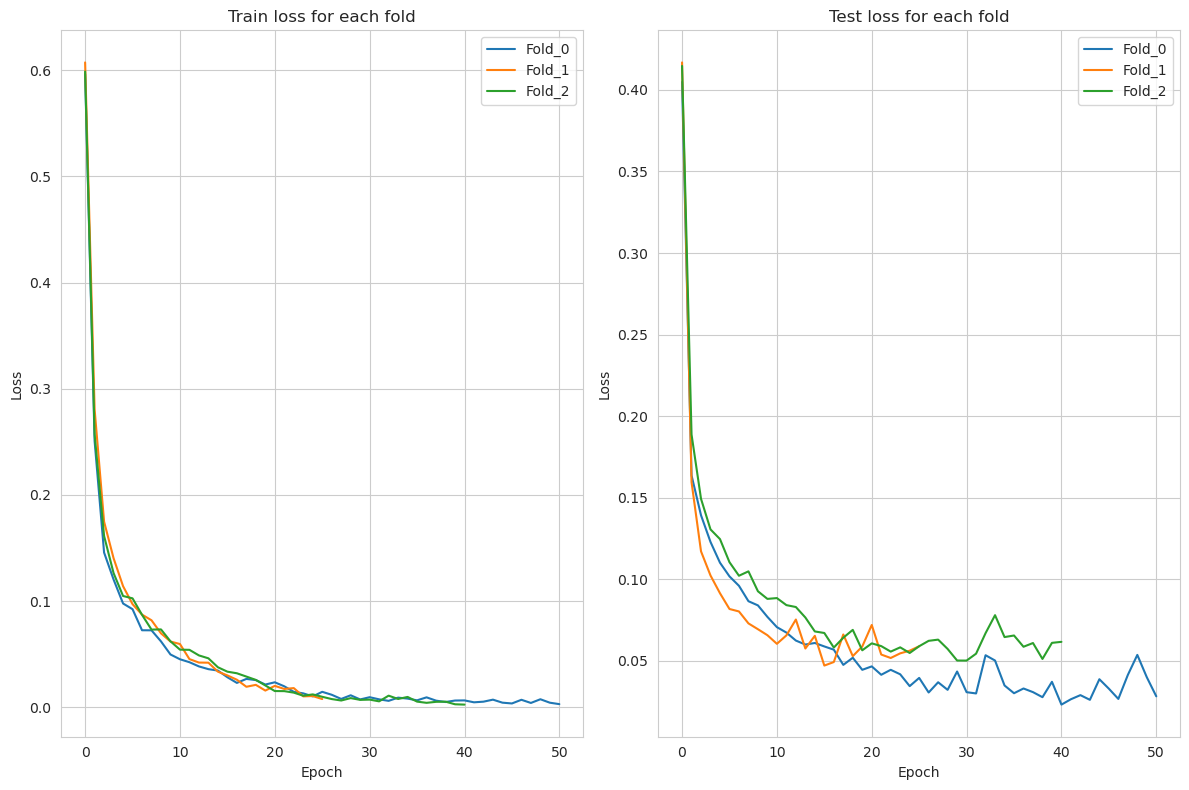

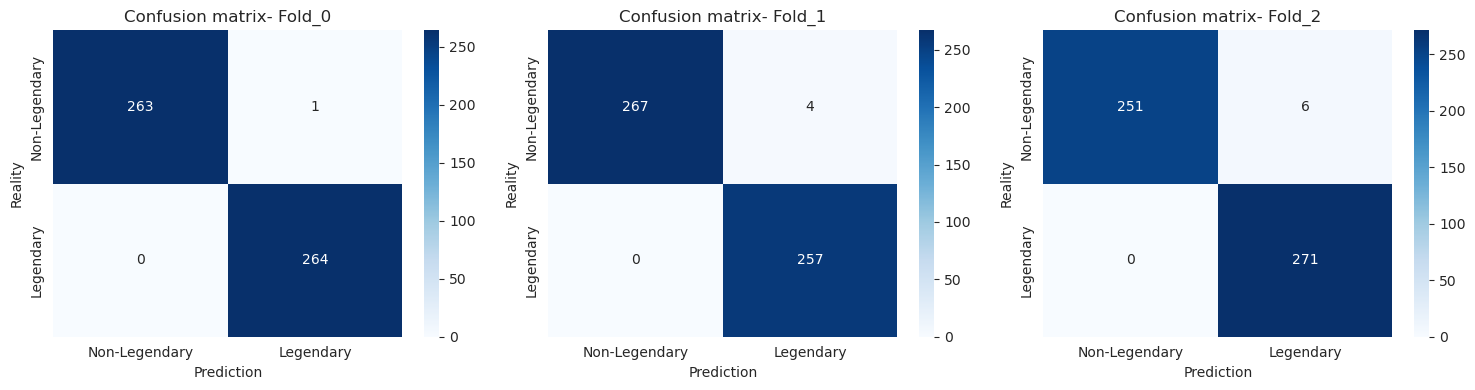

<Figure size 1000x600 with 0 Axes>

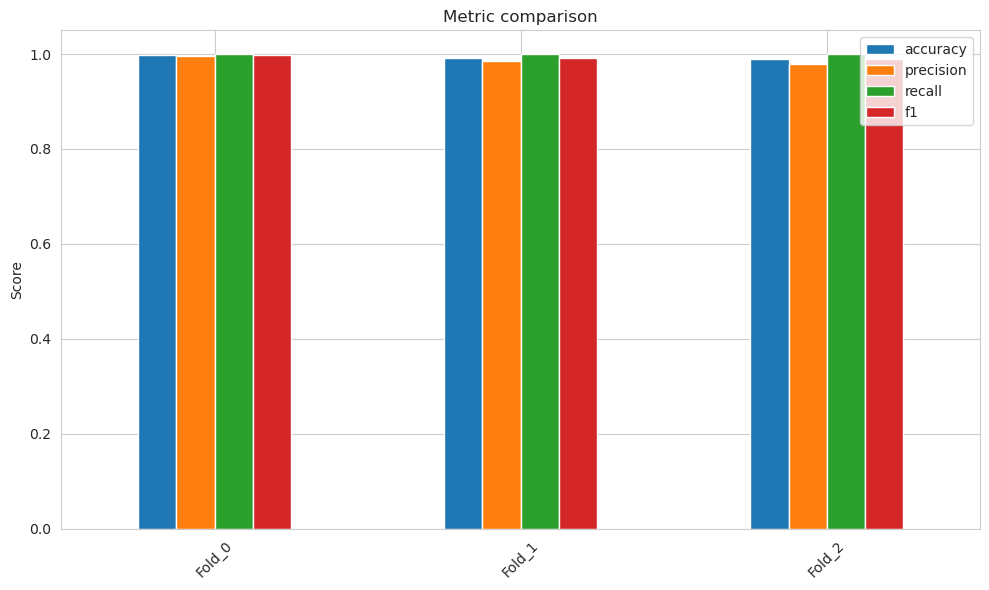

In [8]:
cvResults = optimisationOutput["bestResults"]["cvResults"]
completeCvAnalysis(cvResults)

### Test the model on unknown data

- Load the best model

In [12]:
from torch import optim

bestParams = optimisationOutput["bestParams"]


mlp = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor, hiddenDim= bestParams["hiddenDim"], batchSize= bestParams["batchSize"], numEpoch= bestParams["numEpochs"], nbHiddenLayer = bestParams["nbHiddenLayers"])

# Load the saved state_dict into the model
mlp.model.load_state_dict(torch.load("models/best_model.pth"))

# Ensure the model is in evaluation mode
mlp.model.eval()

# Recreate the optimizer with the model's parameters
mlp.optimiser = optim.Adam(mlp.model.parameters(), lr = bestParams['learningRate'])

- Prediction

In [18]:
testLoss, yProbaPredict = mlp.predict()
print(f"The total loss on test data is {testLoss:4f}.")

The total loss on test data is 0.177281.


- Confusion matrix

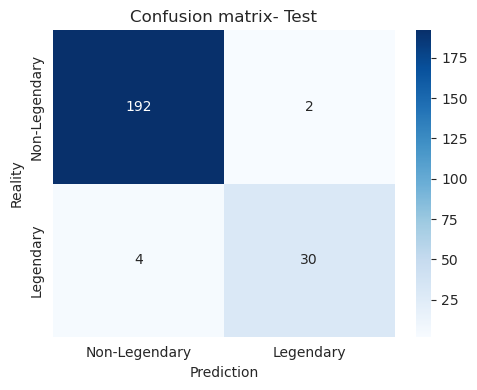

In [19]:
bestThreshold = getBestThresholdsForF1(y_test, yProbaPredict)
yPredClass = mlp.getPredictionClass(bestThreshold)
confusionMatrix = confusion_matrix(y_test, yPredClass)
plotConfusionMatrices({"Test" : {"confusion": confusionMatrix}})

In [20]:
dummyCvResults = getPerformanceStatistics(y_test, yPredClass)
dummyCvResults = {"0": dummyCvResults}
analyseCvOutput(dummyCvResults)

=== Cross validation results===
Accuracy: 0.9737 ± nan
Precision: 0.9375 ± nan
Recall: 0.8824 ± nan
F1: 0.9091 ± nan


,accuracy,precision,recall,f1
0,0.973684,0.9375,0.882353,0.909091


- Thresholds analysis

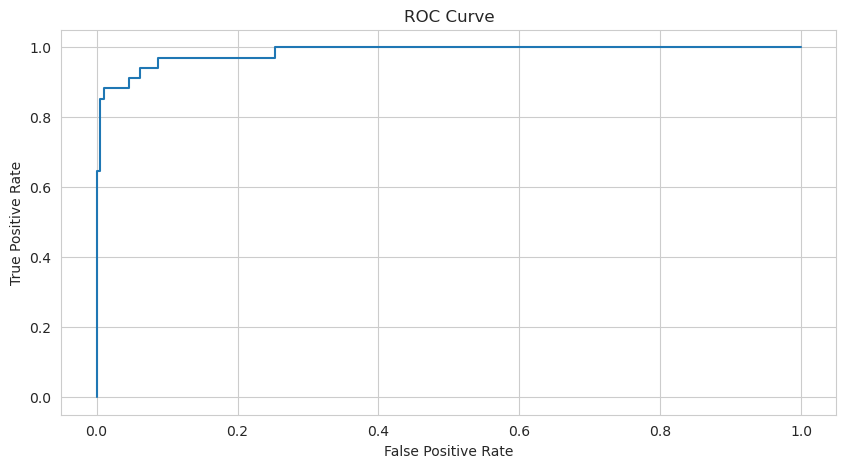

,False positive rate,True positive rate,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.176471,1.000000e+00
2,0.000000,0.235294,9.999999e-01
3,0.000000,0.647059,9.997337e-01
4,0.005155,0.647059,9.996815e-01
5,0.005155,0.852941,9.487887e-01
6,0.010309,0.852941,9.374228e-01
7,0.010309,0.882353,8.525124e-01
8,0.046392,0.882353,5.232600e-03
9,0.046392,0.911765,4.138994e-03


In [21]:
rocCurve(y_test, yProbaPredict)

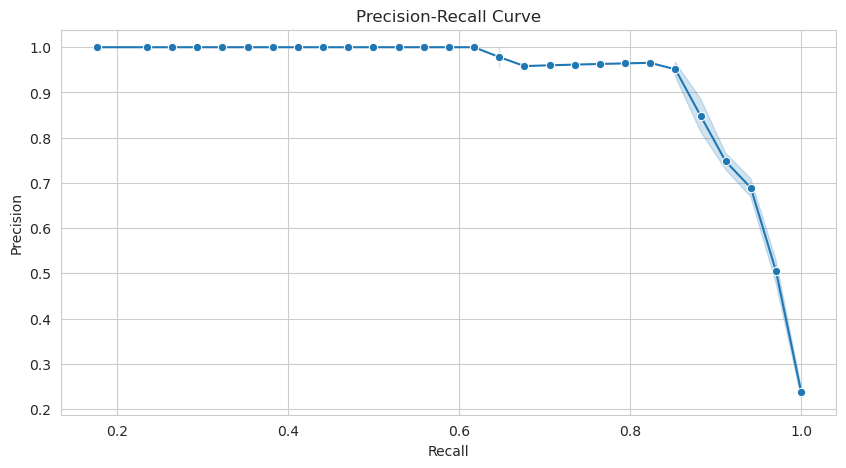

,Precision,Recall,thresholds
0,0.149123,1.000000,2.400284e-16
1,0.149780,1.000000,1.708579e-14
2,0.150442,1.000000,5.559839e-14
3,0.151111,1.000000,6.471632e-14
4,0.151786,1.000000,6.873437e-14
...,...,...,...
215,1.000000,0.323529,9.999989e-01
216,1.000000,0.294118,9.999995e-01
217,1.000000,0.264706,9.999998e-01
218,1.000000,0.235294,9.999999e-01


In [22]:
precisionRecallCurve(y_test, yProbaPredict)

### Processed data visualisation

- Numeric features

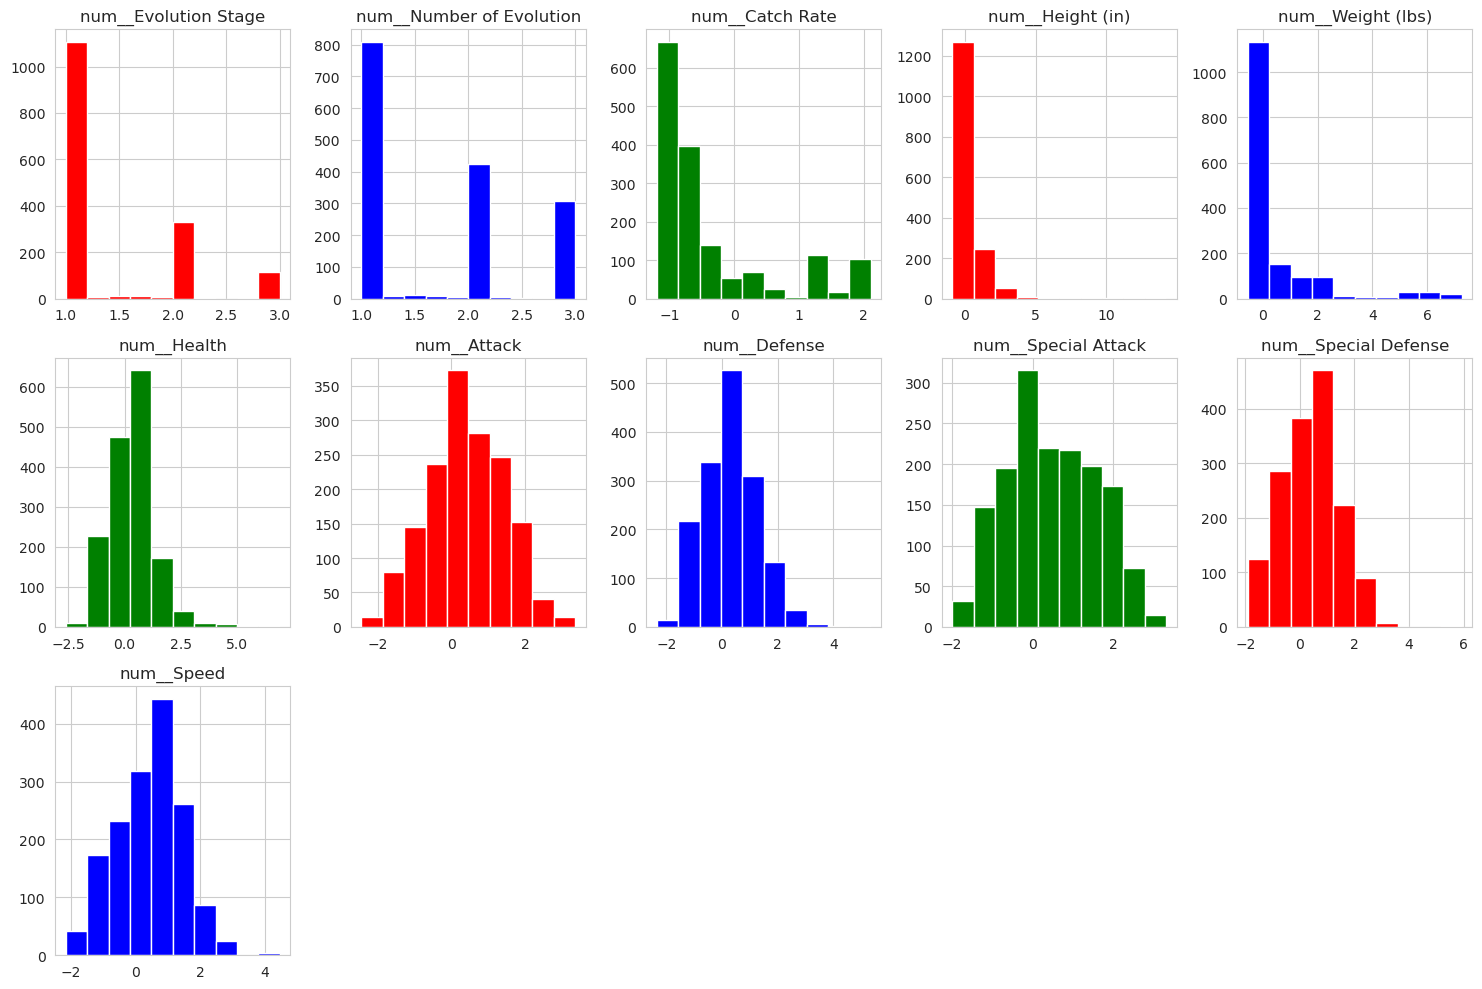

In [23]:
numDataDistribution(X_train_df, nbPlot= 11)

- Categorical features

/mnt/c/Users/EdmondBerne/Documents/MLP_pytorch/MLP_utils.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/mnt/c/Users/EdmondBerne/Documents/MLP_pytorch/MLP_utils.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/mnt/c/Users/EdmondBerne/Documents/MLP_pytorch/MLP_utils.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/mnt/c/Users/EdmondBerne/Documents/MLP_pytorch/MLP_utils.py:131: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)


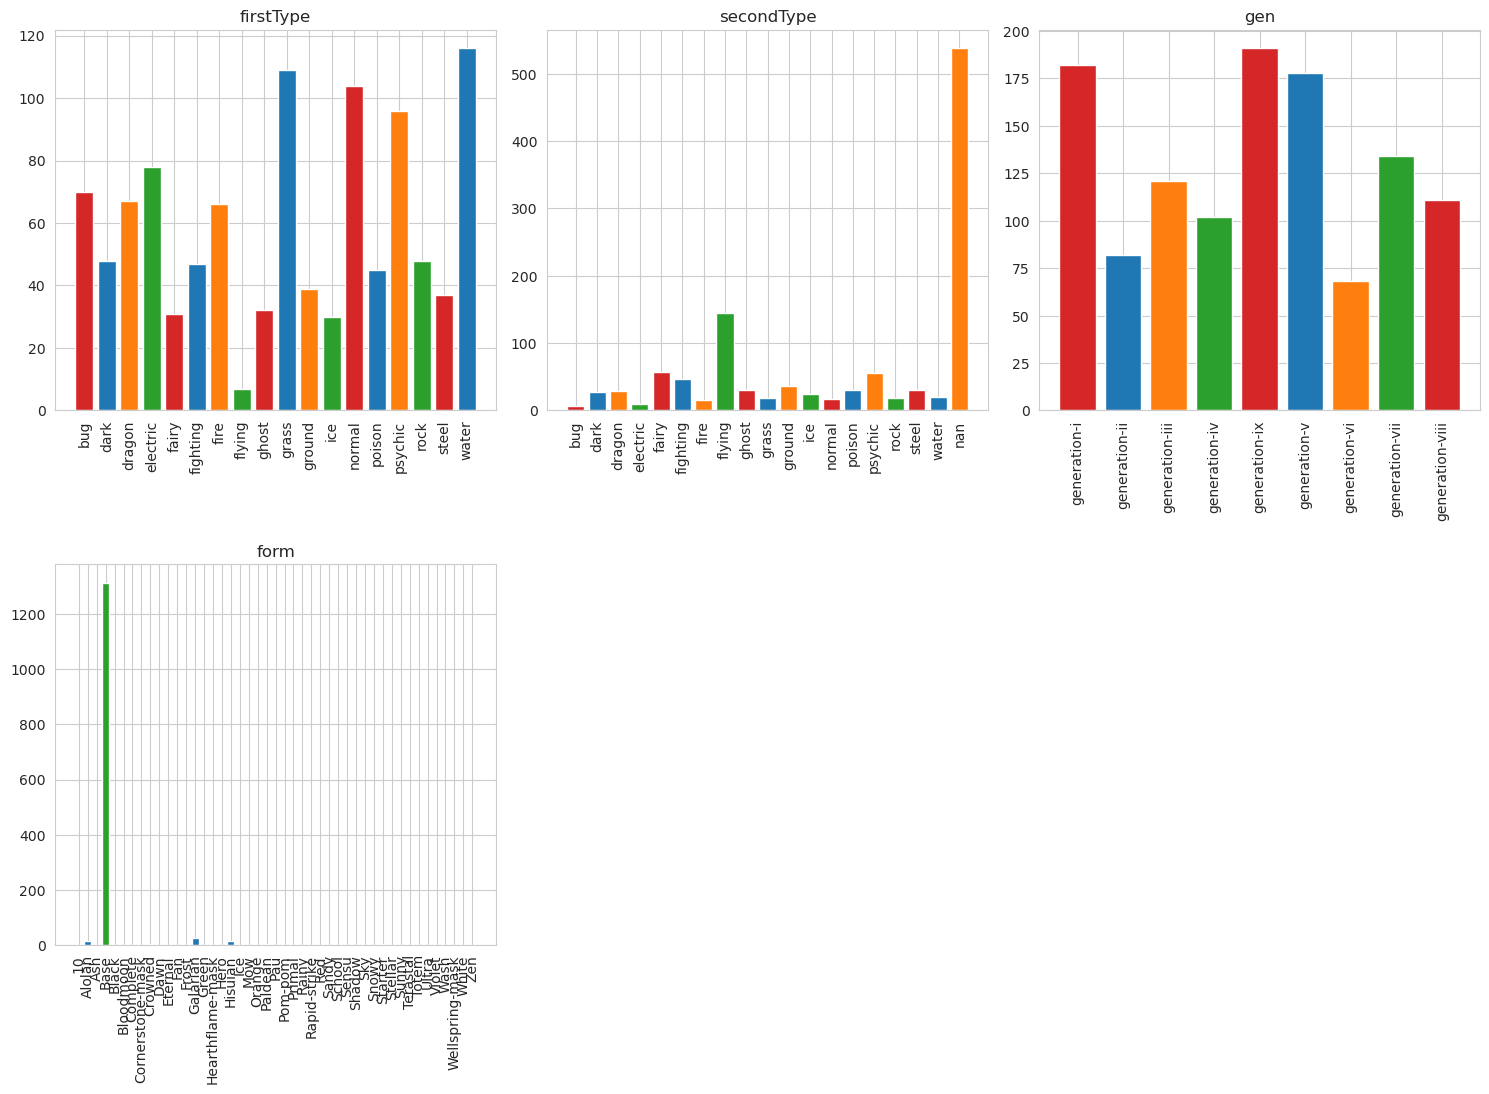

In [24]:
multiplePlot(X_train_df)